First attempt at pulling data from Kaggle and recoding categorical variables of interest into dummy variables.

In [42]:
%matplotlib inline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Structure
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale

# Others
from datetime import datetime
import zipfile
import os.path



# Import Data

In [43]:
# Load the data and examine it
if os.path.isfile('./train.csv'):
    train_data = pd.read_csv('./train.csv')
else:
    z = zipfile.ZipFile('./train.csv.zip')
    train_data = pd.read_csv(z.open('train.csv'))

print("Shape of train_data:", train_data.shape)
train_data.head()

Shape of train_data: (878049, 9)


Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

In [44]:
if os.path.isfile('./test.csv'):
    test_data = pd.read_csv('./test.csv')
else:
    z = zipfile.ZipFile('./test.csv.zip')
    test_data = pd.read_csv(z.open('test.csv'))

print("Shape of test_data:", test_data.shape)
test_data.head()

Shape of test_data: (884262, 7)


Id                Dates DayOfWeek PdDistrict                   Address  \
0   0  2015-05-10 23:59:00    Sunday    BAYVIEW   2000 Block of THOMAS AV   
1   1  2015-05-10 23:51:00    Sunday    BAYVIEW        3RD ST / REVERE AV   
2   2  2015-05-10 23:50:00    Sunday   NORTHERN    2000 Block of GOUGH ST   
3   3  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   
4   4  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   

            X          Y  
0 -122.399588  37.735051  
1 -122.391523  37.732432  
2 -122.426002  37.792212  
3 -122.437394  37.721412  
4 -122.437394  37.721412

In [45]:
# Import San Francisco map for visualization
mapdata = np.loadtxt("./sf_map_copyright_openstreetmap_contributors.txt")
len_width_ratio = mapdata.shape[0] * 1.0 / mapdata.shape[1]

# Data Cleansing

In [46]:
print('Before data cleansing, the train data contain %d samples, the test data contain %d samples.' % \
      (train_data.shape[0], test_data.shape[0]))

# Drop samples containing null fields
train_data = train_data.dropna()
test_data = test_data.dropna()

# The boundaries of valid longitude and latitude
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

# Drop samples containing invalide longitude and latitude
train_data = train_data[train_data.X > lon_lat_box[0]]
train_data = train_data[train_data.X < lon_lat_box[1]]
train_data = train_data[train_data.Y > lon_lat_box[2]]
train_data = train_data[train_data.Y < lon_lat_box[3]]

test_data = test_data[test_data.X > lon_lat_box[0]]
test_data = test_data[test_data.X < lon_lat_box[1]]
test_data = test_data[test_data.Y > lon_lat_box[2]]
test_data = test_data[test_data.Y < lon_lat_box[3]]

print('After data cleansing, the train data contain %d samples, the test data contain %d samples.' % \
      (train_data.shape[0], test_data.shape[0]))

Before data cleansing, the train data contain 878049 samples, the test data contain 884262 samples.
After data cleansing, the train data contain 877982 samples, the test data contain 884186 samples.


#  Exploratory Data Analysis

There are 39 crime categories.
LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY            

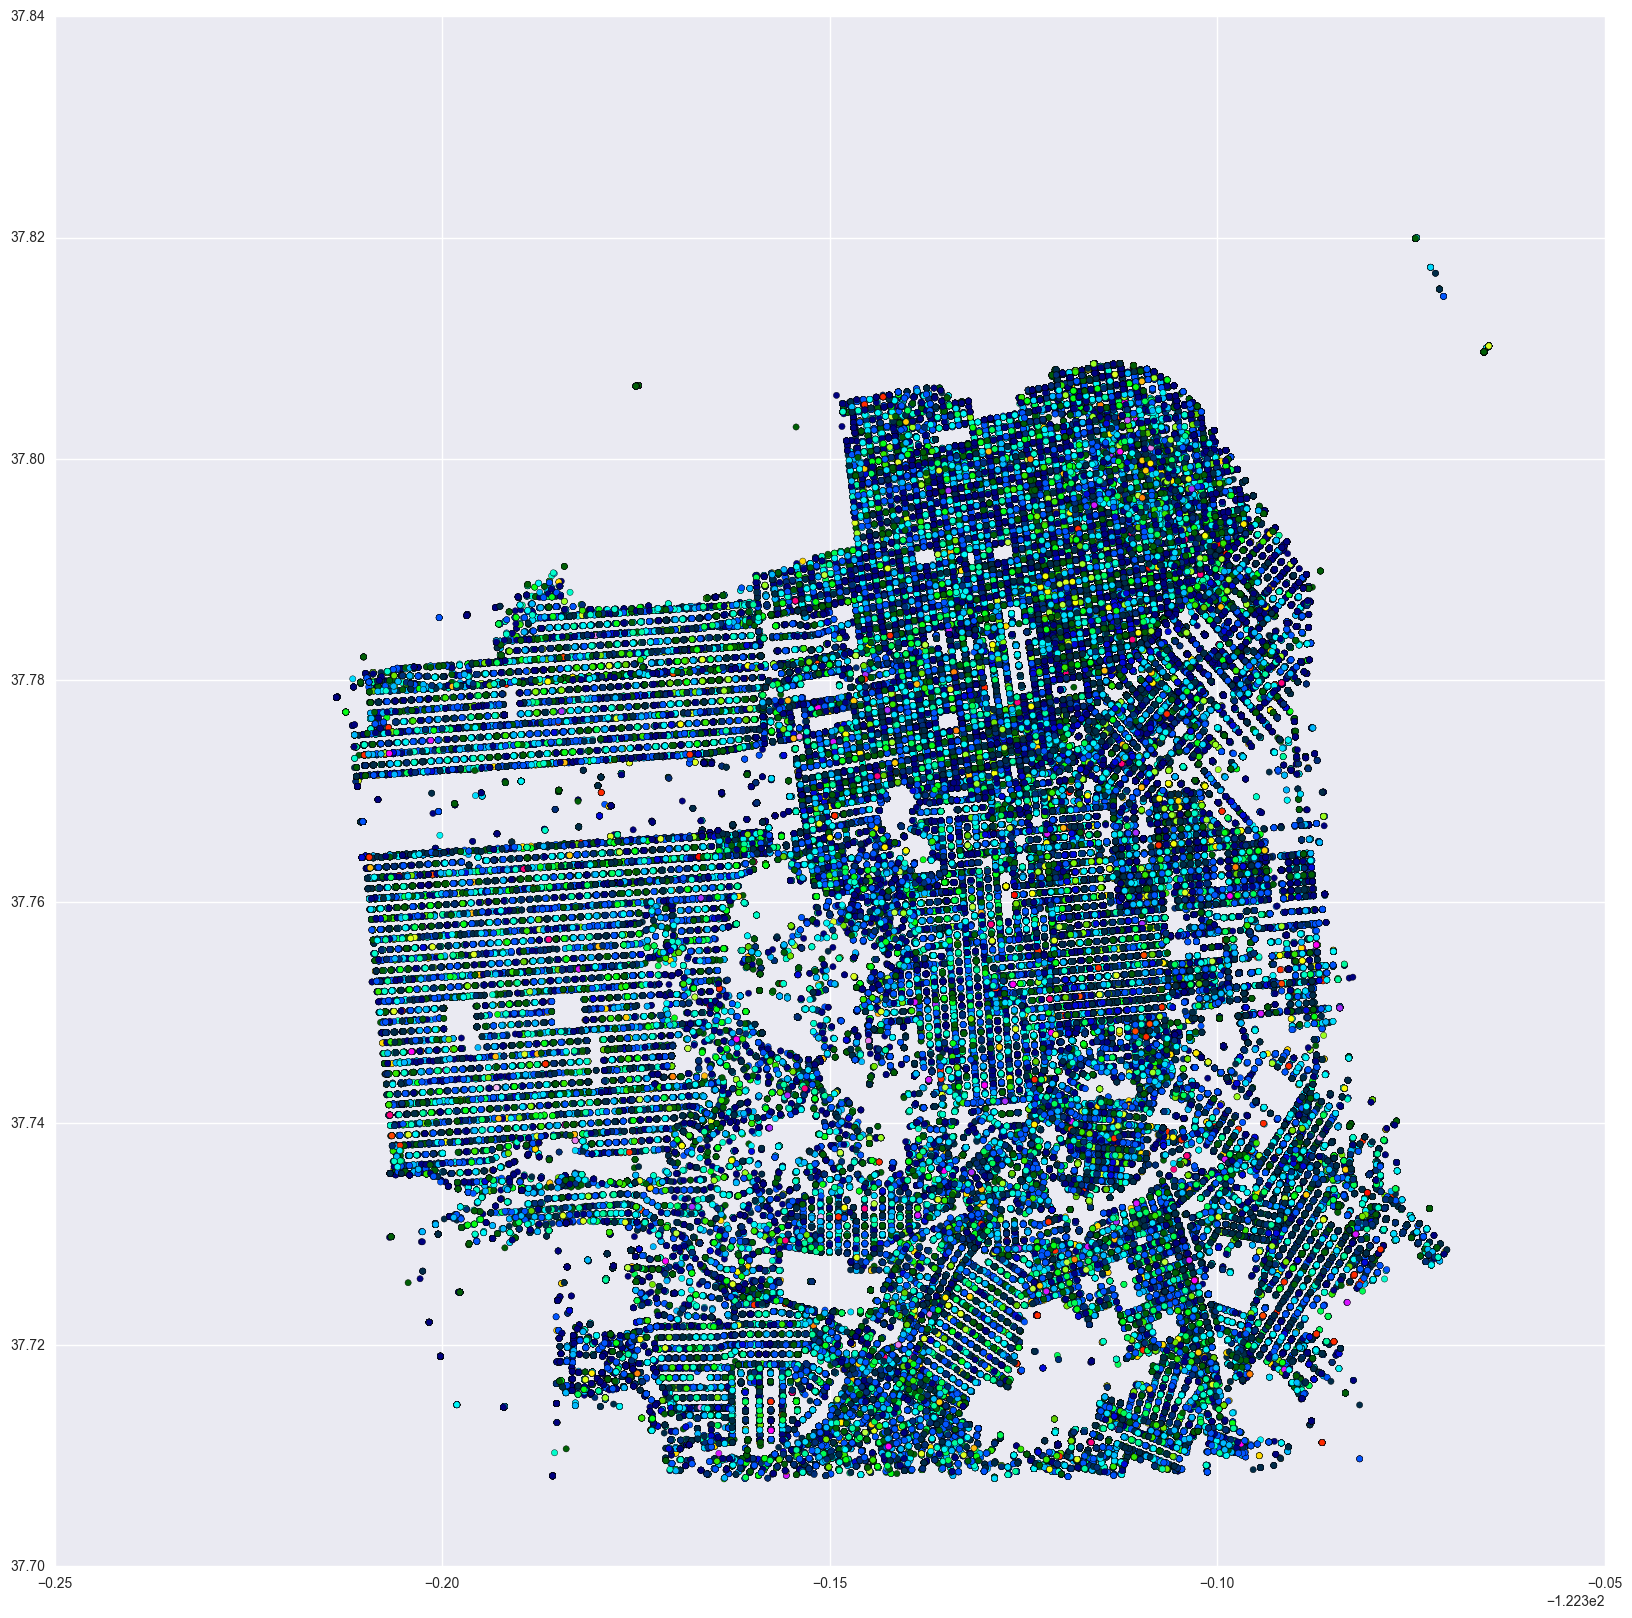

In [47]:
# Show all available crime lables.
crime_categories = train_data['Category'].value_counts()
print('There are %d crime categories.' % (len(crime_categories)))
print(crime_categories)
crime_category_names = crime_categories.index

# Assign a color index to each crime category
color_map = dict(zip(crime_category_names, range(len(crime_categories))))

# Draw a scatter plot to show the crimes distribution
plt.figure(figsize=(20,20))
plt.scatter(train_data.X, train_data.Y, c=train_data.Category.map(color_map), cmap=plt.cm.gist_ncar)

Apparently, the scatter plot with all crimes is not very helpful. Crimes happened everywhere, and we didn't get deeper insight. We will make the scatter plot of every crime separatedly at the next step.

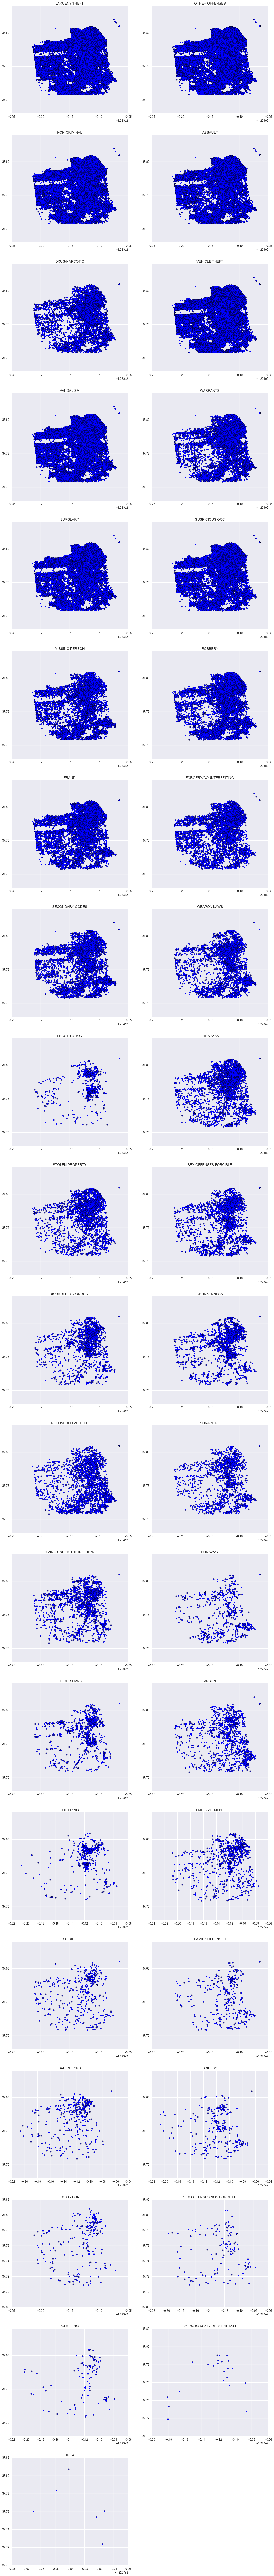

In [48]:
plt.figure(figsize=(16, 320))

# For Python2 vs Python3 compatibility
try:
    xrange
except NameError:
    xrange = range
 
for i in xrange(len(crime_category_names)):
    p = plt.subplot(40, 2, i+1)
    crime = crime_category_names[i]
    cur_crime_data = train_data[train_data.Category == crime]
    plt.title(crime)
    p.scatter(cur_crime_data.X, cur_crime_data.Y)

    

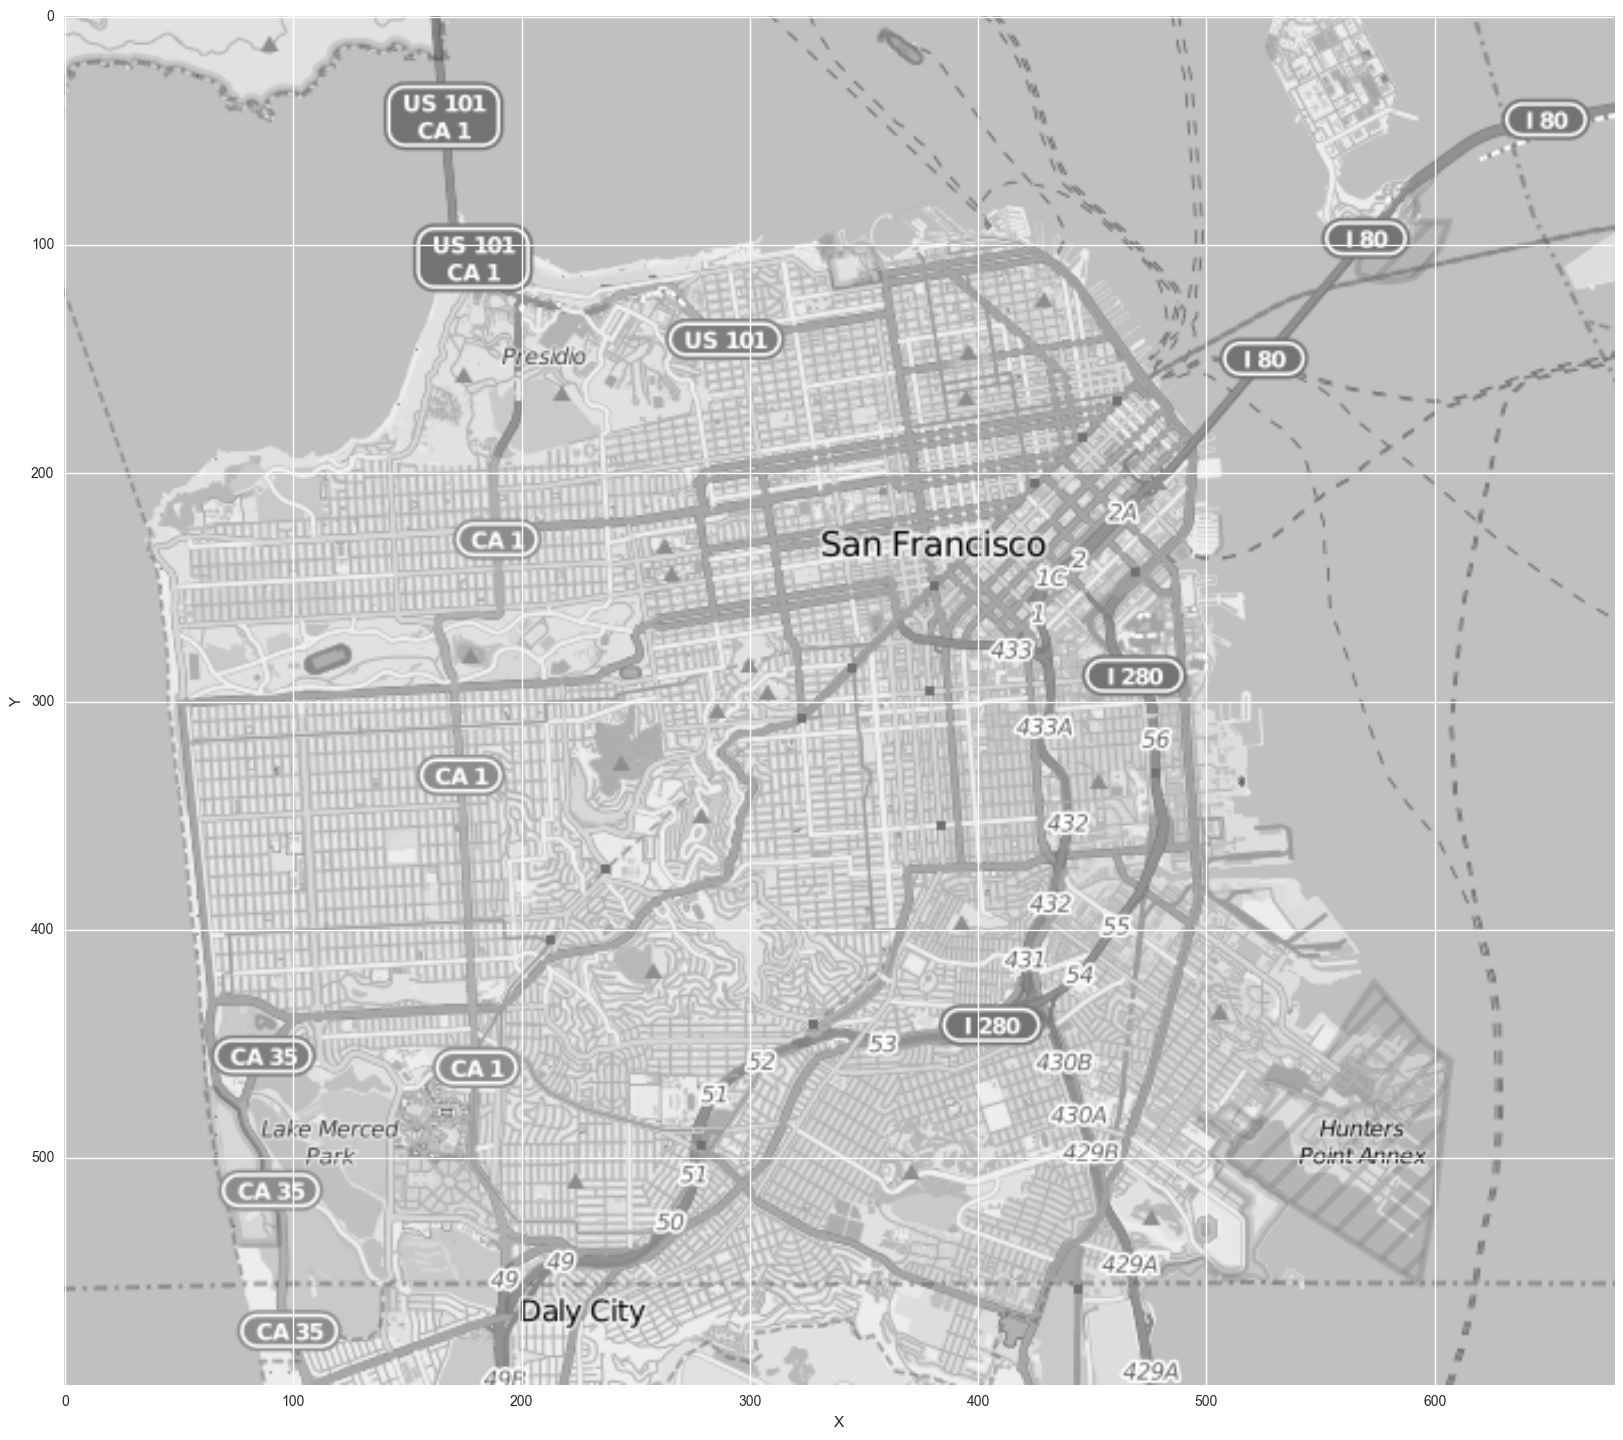

In [49]:
#Do a larger plot with prostitution only
plt.figure(figsize=(20,20))
trainP = train_data.loc[train_data['Category'] == 'PROSTITUTION']
ax = sns.kdeplot(trainP.X, trainP.Y)
ax.imshow(mapdata, cmap=plt.get_cmap('gray'))

In [50]:
# At the second step, we want to see the basic info of our data.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 878048
Data columns (total 9 columns):
Dates         877982 non-null object
Category      877982 non-null object
Descript      877982 non-null object
DayOfWeek     877982 non-null object
PdDistrict    877982 non-null object
Resolution    877982 non-null object
Address       877982 non-null object
X             877982 non-null float64
Y             877982 non-null float64
dtypes: float64(2), object(7)
memory usage: 67.0+ MB


In [51]:
# Show all available crime lables.
print(train_data['Category'].value_counts())

# Show the percentage of the mode in all data. If the prediction of the model is worse than always predicting the mode,
# then we should always predict the mode in the baseline establishment.
print('The percentage of the LARCENY/THEFT is: ', train_data['Category'].value_counts()[0] * 1.0 / train_data.shape[0])

LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [52]:
# Convert the date into a python datetime object.
train_data["Dates"] = pd.to_datetime(train_data["Dates"], format="%Y-%m-%d %H:%M:%S")
test_data["Dates"] = pd.to_datetime(test_data["Dates"], format="%Y-%m-%d %H:%M:%S")

In [72]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 878048
Data columns (total 9 columns):
Dates         877982 non-null datetime64[ns]
Category      877982 non-null object
Descript      877982 non-null object
DayOfWeek     877982 non-null object
PdDistrict    877982 non-null object
Resolution    877982 non-null object
Address       877982 non-null object
X             877982 non-null float64
Y             877982 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 67.0+ MB


# Daghan's addition

In [85]:
from sklearn.preprocessing import LabelEncoder

print(train_data.shape, test_data.shape)

#let's back stuff up
# Before we train the models, we need to divide the data into train data and dev data.
train1_data = train_data.copy()

# split to train / dev 
shuffle = np.random.permutation(np.arange(train1_data.shape[0]))
train1_data = train1_data.iloc[shuffle]
train1_labels = train1_data['Category']

train1_data["Hour"] = train_data["Dates"].apply(lambda x: x.hour)

# drop unnecessary stuff
train1_data = train1_data.drop(['Category','Address','Dates'], axis=1)
    

# normalize X and Y
train1_data[['X','Y']] = scale(train1_data[['X','Y']])

# let's create integer values for each categories (akin to as.Factor() in R)
train1_data['Descript'] = LabelEncoder().fit_transform(train1_data['Descript'])
train1_data['Resolution'] = LabelEncoder().fit_transform(train1_data['Resolution'])
train1_data['DayOfWeek'] = LabelEncoder().fit_transform(train1_data['DayOfWeek'])
train1_data['PdDistrict'] = LabelEncoder().fit_transform(train1_data['PdDistrict'])


mini_train1_data = train1_data.iloc[:10000]
mini_train1_labels = train1_labels.iloc[:10000]

mini_dev_data = train1_data.iloc[10000:11000]
mini_dev_labels = train1_labels.iloc[10000:11000]

print(train1_data.shape,train1_labels.shape)
print(mini_train1_data.shape, mini_train1_labels.shape, mini_dev_data.shape, mini_dev_labels.shape)

print(mini_train1_data.head())

(877982, 9) (884186, 7)
(877982, 7) (877982,)
(10000, 7) (10000,) (1000, 7) (1000,)
        Descript  DayOfWeek  PdDistrict  Resolution         X         Y  Hour
276230       866          4           3           0  0.239377 -0.442244    11
33748        404          0           1          11  0.150307  1.532872    21
345232       496          2           4          11 -0.727106  1.351862     2
692470       390          3           0          11  1.438252 -0.319034    16
329322        24          0           7          11  0.828408  0.885835    13


In [86]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(mini_train1_data, mini_train1_labels)

pred_labels = random_forest.predict(mini_dev_data)
rf_accuracy = np.mean(mini_dev_labels == pred_labels)
print(rf_accuracy)
random_forest.score(mini_dev_data, mini_dev_labels)

0.833


0.83299999999999996

# End of Daghan's addition

In [31]:
# Add 24 binary features representing the happening hour of the crime.
hour_map = {0:'Zero', 1:'One', 2:'Two', 3:'Three', 4:'Four', 5:'Five', 6:'Six', 7:'Seven', 8:'Eight', 9:'Nine', 
            10:'Ten', 11:'Eleven', 12:'Twelve', 13:'Thirteen', 14:'Fourteen', 15:'Fifteen', 16:'Sixteen', 
            17:'Seventeen', 18:'Eighteen', 19:'Nineteen', 20:'Twenty', 21:'TwentyOne', 22:'TwentyTwo', 
            23:'TwentyThree'}

train_data["Hour"] = train_data["Dates"].apply(lambda x: x.hour)
for hour in train_data["Hour"].unique():
    train_data[hour_map[hour]] = pd.Series(train_data["Hour"] == hour, dtype=int)
     
test_data["Hour"] = test_data["Dates"].apply(lambda x: x.hour)
for hour in test_data["Hour"].unique():
    test_data[hour_map[hour]] = pd.Series(test_data["Hour"] == hour, dtype=int)
    
train_data.iloc[:5,-24:]

TwentyThree  TwentyTwo  TwentyOne  Twenty  Nineteen  Eighteen  Seventeen  \
0            1          0          0       0         0         0          0   
1            1          0          0       0         0         0          0   
2            1          0          0       0         0         0          0   
3            1          0          0       0         0         0          0   
4            1          0          0       0         0         0          0   

   Sixteen  Fifteen  Fourteen  ...   Nine  Eight  Seven  Six  Five  Four  \
0        0        0         0  ...      0      0      0    0     0     0   
1        0        0         0  ...      0      0      0    0     0     0   
2        0        0         0  ...      0      0      0    0     0     0   
3        0        0         0  ...      0      0      0    0     0     0   
4        0        0         0  ...      0      0      0    0     0     0   

   Three  Two  One  Zero  
0      0    0    0     0  
1      0    0    0     0  
2      0    0    0     0  
3      0    0    0     0  
4      0    0    0     0  

[5 rows x 24 columns]

In [32]:
# Add 12 binary features representing the happening month of the crime.
month_map = {1:'January', 2:'February ', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September',
             10:'October', 11:'November', 12:'December'}

train_data["Month"] = train_data["Dates"].apply(lambda x: x.month)
for month in train_data["Month"].unique():
    train_data[month_map[month]] = pd.Series(train_data["Month"] == month, dtype=int)
    
test_data["Month"] = test_data["Dates"].apply(lambda x: x.month)
for month in test_data["Month"].unique():
    test_data[month_map[month]] = pd.Series(test_data["Month"] == month, dtype=int)
    
train_data.iloc[:5,-12:]

May  April  March  February   January  December  November  October  \
0    1      0      0          0        0         0         0        0   
1    1      0      0          0        0         0         0        0   
2    1      0      0          0        0         0         0        0   
3    1      0      0          0        0         0         0        0   
4    1      0      0          0        0         0         0        0   

   September  August  July  June  
0          0       0     0     0  
1          0       0     0     0  
2          0       0     0     0  
3          0       0     0     0  
4          0       0     0     0

In [33]:
# Add 12 binary features representing the happening year of the crime.
train_data["Year"] = train_data["Dates"].apply(lambda x: x.year)
for year in train_data["Year"].unique():
    train_data[year] = pd.Series(train_data["Year"] == year, dtype=int)
    
test_data["Year"] = test_data["Dates"].apply(lambda x: x.year)
for year in test_data["Year"].unique():
    test_data[year] = pd.Series(test_data["Year"] == year, dtype=int)

train_data.iloc[:5,-13:]

2015  2014  2013  2012  2011  2010  2009  2008  2007  2006  2005  2004  \
0     1     0     0     0     0     0     0     0     0     0     0     0   
1     1     0     0     0     0     0     0     0     0     0     0     0   
2     1     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     0     0     0     0     0     0   
4     1     0     0     0     0     0     0     0     0     0     0     0   

   2003  
0     0  
1     0  
2     0  
3     0  
4     0

In [34]:
# Add 7 binary features representing the happening date of week of the crime.
for day_of_week in train_data["DayOfWeek"].unique():
    train_data[day_of_week] = pd.Series(train_data["DayOfWeek"] == day_of_week, dtype=int)
    
for day_of_week in test_data["DayOfWeek"].unique():
    test_data[day_of_week] = pd.Series(test_data["DayOfWeek"] == day_of_week, dtype=int)
    
# Add 10 binary features representing the district of the crime.
for district in train_data["PdDistrict"].unique():
    train_data[district] = pd.Series(train_data["PdDistrict"] == district, dtype=int)
    
for district in test_data["PdDistrict"].unique():
    test_data[district] = pd.Series(test_data["PdDistrict"] == district, dtype=int)

In [35]:
# Normalize X and Y

#Daghan: Perhaps this is more succint?
train_data[['X','Y']] = scale(train_data[['X','Y']])
test_data[['X','Y']] = scale(test_data[['X','Y']])

#x_mean = train_data["X"].mean()
#x_std = train_data["X"].std()
#y_mean = train_data["Y"].mean()
#y_std = train_data["Y"].std()
#train_data['X'] = train_data["X"].apply(lambda x: (x - x_mean) /  x_std).round(3)
#train_data['Y'] = train_data["Y"].apply(lambda y: (y - y_mean) /  y_std).round(3)


#x_mean = test_data["X"].mean()
#x_std = test_data["X"].std()
#y_mean = test_data["Y"].mean()
#y_std = test_data["Y"].std()
#test_data['X'] = test_data["X"].apply(lambda x: (x - x_mean) /  x_std).round(3)
#test_data['Y'] = test_data["Y"].apply(lambda y: (y - y_mean) /  y_std).round(3)
train_data.describe()

X             Y           Hour    TwentyThree  \
count  8.779820e+05  8.779820e+05  877982.000000  877982.000000   
mean   7.451252e-13  2.362082e-13      13.412737       0.048357   
std    1.000001e+00  1.000001e+00       6.549521       0.214521   
min   -3.594245e+00 -2.448026e+00       0.000000       0.000000   
25%   -4.029502e-01 -6.044895e-01       9.000000       0.000000   
50%    2.508867e-01  3.470394e-01      14.000000       0.000000   
75%    6.250658e-01  7.172913e-01      19.000000       0.000000   
max    2.286996e+00  2.190842e+00      23.000000       1.000000   

           TwentyTwo      TwentyOne         Twenty       Nineteen  \
count  877982.000000  877982.000000  877982.000000  877982.000000   
mean        0.052098       0.049727       0.050900       0.056347   
std         0.222225       0.217380       0.219793       0.230591   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

            Eighteen      Seventeen      ...             NORTHERN  \
count  877982.000000  877982.000000      ...        877982.000000   
mean        0.062752       0.060990      ...             0.119916   
std         0.242516       0.239312      ...             0.324863   
min         0.000000       0.000000      ...             0.000000   
25%         0.000000       0.000000      ...             0.000000   
50%         0.000000       0.000000      ...             0.000000   
75%         0.000000       0.000000      ...             0.000000   
max         1.000000       1.000000      ...             1.000000   

                PARK      INGLESIDE        BAYVIEW       RICHMOND  \
count  877982.000000  877982.000000  877982.000000  877982.000000   
mean        0.056164       0.089798       0.101849       0.051484   
std         0.230238       0.285892       0.302450       0.220983   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

             CENTRAL        TARAVAL     TENDERLOIN        MISSION  \
count  877982.000000  877982.000000  877982.000000  877982.000000   
mean        0.097331       0.074708       0.093161       0.136571   
std         0.296408       0.262919       0.290659       0.343394   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

            SOUTHERN  
count  877982.000000  
mean        0.179017  
std         0.383367  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 71 columns]

In [36]:
# Drop the unnecessary feature columns from the train data.
train_data = train_data.drop(['Hour', 'Month', 'Year', 'Dates', 'DayOfWeek', 'PdDistrict', 
                              'Descript', 'Resolution', 'Address'], axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 878048
Data columns (total 69 columns):
Category       877982 non-null object
X              877982 non-null float64
Y              877982 non-null float64
TwentyThree    877982 non-null int64
TwentyTwo      877982 non-null int64
TwentyOne      877982 non-null int64
Twenty         877982 non-null int64
Nineteen       877982 non-null int64
Eighteen       877982 non-null int64
Seventeen      877982 non-null int64
Sixteen        877982 non-null int64
Fifteen        877982 non-null int64
Fourteen       877982 non-null int64
Thirteen       877982 non-null int64
Twelve         877982 non-null int64
Eleven         877982 non-null int64
Ten            877982 non-null int64
Nine           877982 non-null int64
Eight          877982 non-null int64
Seven          877982 non-null int64
Six            877982 non-null int64
Five           877982 non-null int64
Four           877982 non-null int64
Three          877982 non-null in

# Machine Learning

In [37]:
# Before we train the models, we need to divide the data into train data and dev data.
shuffle = np.random.permutation(np.arange(train_data.shape[0]))

train_data = train_data.iloc[shuffle]


train_labels = train_data['Category']
train_data = train_data.drop('Category', axis=1)

mini_train_data = train_data.iloc[:10000]
mini_train_labels = train_labels.iloc[:10000]

mini_dev_data = train_data.iloc[10000:11000]
mini_dev_labels = train_labels.iloc[10000:11000]

print(train_data.shape,train_labels.shape)
print(mini_train_data.shape, mini_train_labels.shape, mini_dev_data.shape, mini_dev_labels.shape)

(877982, 68) (877982,)
(10000, 68) (10000,) (1000, 68) (1000,)


In [38]:
# Now we train some most common models to see the performance.

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(mini_train_data, mini_train_labels)
pred_labels = logreg.predict(mini_dev_data)
logreg_accuracy = np.mean(mini_dev_labels == pred_labels)

# Support Vector Machines
svc = SVC()
svc.fit(mini_train_data, mini_train_labels)
pred_labels = svc.predict(mini_dev_data)
svc_accuracy = np.mean(mini_dev_labels == pred_labels)

# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(mini_train_data, mini_train_labels)
pred_labels = knn.predict(mini_dev_data)
knn_accuracy = np.mean(mini_dev_labels == pred_labels)

# Naive Bayes
gaussian = GaussianNB()
gaussian.fit(mini_train_data, mini_train_labels)
pred_labels = gaussian.predict(mini_dev_data)
nb_accuracy = np.mean(mini_dev_labels == pred_labels)

# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(mini_train_data, mini_train_labels)
pred_labels = decision_tree.predict(mini_dev_data)
dt_accuracy = np.mean(mini_dev_labels == pred_labels)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(mini_train_data, mini_train_labels)
pred_labels = random_forest.predict(mini_dev_data)
rf_accuracy = np.mean(mini_dev_labels == pred_labels)

# Neural Network
ann = MLPClassifier()
ann.fit(mini_train_data, mini_train_labels)
pred_labels = ann.predict(mini_dev_data)
ann_accuracy = np.mean(mini_dev_labels == pred_labels)

# Display the rank of the models
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Neural Network', 'Decision Tree'],
    'Accuracy': [svc_accuracy, knn_accuracy, logreg_accuracy, 
              rf_accuracy, nb_accuracy, ann_accuracy, dt_accuracy]})
models.sort_values(by='Accuracy', ascending=False)

//anaconda/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Accuracy                    Model
2     0.224      Logistic Regression
3     0.214            Random Forest
0     0.210  Support Vector Machines
5     0.165           Neural Network
6     0.145            Decision Tree
1     0.119                      KNN
4     0.007              Naive Bayes

In [39]:
# We will use the Random Forest to establish the baseline.

# Retrain the Random Forest model with full train data
random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [40]:
# Import the test data and use the selected model to predict
test_pred = logreg.predict(test_data.drop(['Hour', 'Month', 'Year', 'Dates', 'DayOfWeek', 'PdDistrict', 
                            'Id', 'Address'], axis=1))

In [41]:
# Save the prediction data to a csv file.

id_column = np.array(range(test_pred.shape[0]), dtype=int)
np_matrix = np.column_stack((id_column, test_pred))
df = pd.DataFrame(data=np_matrix, columns=['Id', 'Category'])

# Transform the np matrix to a dataframe compliant with the submission standard 
for crime in df["Category"].unique():
    df[crime] = pd.Series(df["Category"] == crime, dtype=int)
    
# Add columns for crime appearing in the train data but not the prediction data
for crime in crime_data['Category'].unique():
    if crime not in df:
        df[crime] = pd.Series([0] * test_pred.shape[0], dtype=int)
    
# Rearrange the columns in lexical order to comply with the submission format
df = df.reindex_axis([df.columns[0]] + sorted(df.columns[1:]), axis=1)

# Drop the unnecessary column
df = df.drop('Category', axis=1)
df.info()

# Save the submission file locally
df.to_csv('./submission.csv', index=False)

NameError: name 'crime_data' is not defined